# Reactive Planner - Getting Started

This tutorial gives you a quick overview on how to use the reactive planner for motion planning on CommonRoad scenarios.

**Pre-requisites:**
Before getting started, please make sure you are familiar with the CommonRoad format and have a brief understanding of the following tools: **CommonRoad-Input-Output, CommonRoad-Route-Planner, CommonRoad-Drivability-Checker** 

**Content**
In the following sections, we provide step-by-step instructions for using the reactive planner on a simple scenario. This includes:
* loading a scenario and creating the planner configuration
* planning a high-level route and reference path
* sampling trajectories
* running the planner within a cyclic re-planning loop

_Note: The content of this tutorial is also provided within the example script `run_planner.py`_

## Load scenario and create planner configuration
The scenario is loaded from an XML file in `example_scenarios/`. 

The planner configuration is loaded from the YAML file in the tutorial folder. If no YAML file is provided, the default configuration values are chosen from `utility/config.py`.

In [1]:
from commonroad_rp.utility.config import ReactivePlannerConfiguration

# scenario filename
filename = "ZAM_Over-1_1.xml"

# Build planner configuration object
config = ReactivePlannerConfiguration.load(f"tutorial_config_{filename[:-4]}.yaml", filename)
config.update()

# Scenario and planning problem are automatically loaded in the config
scenario = config.scenario
planning_problem = config.planning_problem

Show the scenario and planning problem: We see the initial state and goal region as well as one static obstacle

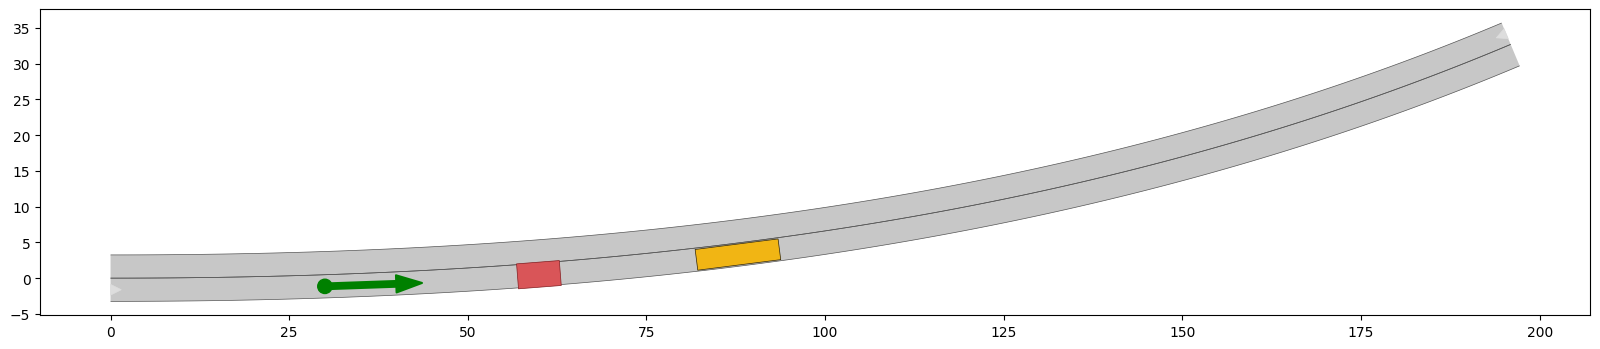

In [2]:
from commonroad_rp.utility.visualization import visualize_scenario_and_pp

visualize_scenario_and_pp(scenario, planning_problem)

## Plan a route and reference path
We use the CommonRoad Route Planner to plan a route and reference path to the goal region

In [3]:
from commonroad_route_planner.route_planner import RoutePlanner

# run route planner
route_planner = RoutePlanner(config.scenario, config.planning_problem)
route = route_planner.plan_routes().retrieve_first_route()

# get reference path
reference_path = route.reference_path

Lanelets_of_goal_position not given


## Initialize reactive planner
We initialize the planner from with the previously create config object and set the reference path

In [4]:
from commonroad_rp.reactive_planner import ReactivePlanner

# initialize reactive planner
planner = ReactivePlanner(config)

# set reference path for curvilinear coordinate system
planner.set_reference_path(route.reference_path)

<ProjectionDomain/approximateProjectionDomain>: Using method number: 1
<ProjectionDomain/approximateProjectionDomain>: Computing projection domain border took: 9770 nanoseconds.
<CurvilinearCoordinateSystem/computeBestProjectionAxisForSegments>: Pre-computing projection axis for segments took: 26808 nanoseconds.


## Run one sampling step of the planner
We now run one planning step of the reactive planner and visualize the set of generated trajectory samples as well as the chosen optimal trajectory. The trajectories are generated for a fixed time horizon specified by `time_steps_computation` in the config and set to 20 time steps (i.e., 2 seconds) for this example.

The generated set of trajectory samples is shown in blue and the planned (optimal) trajectory is shown in black. The reference path is shown in green.

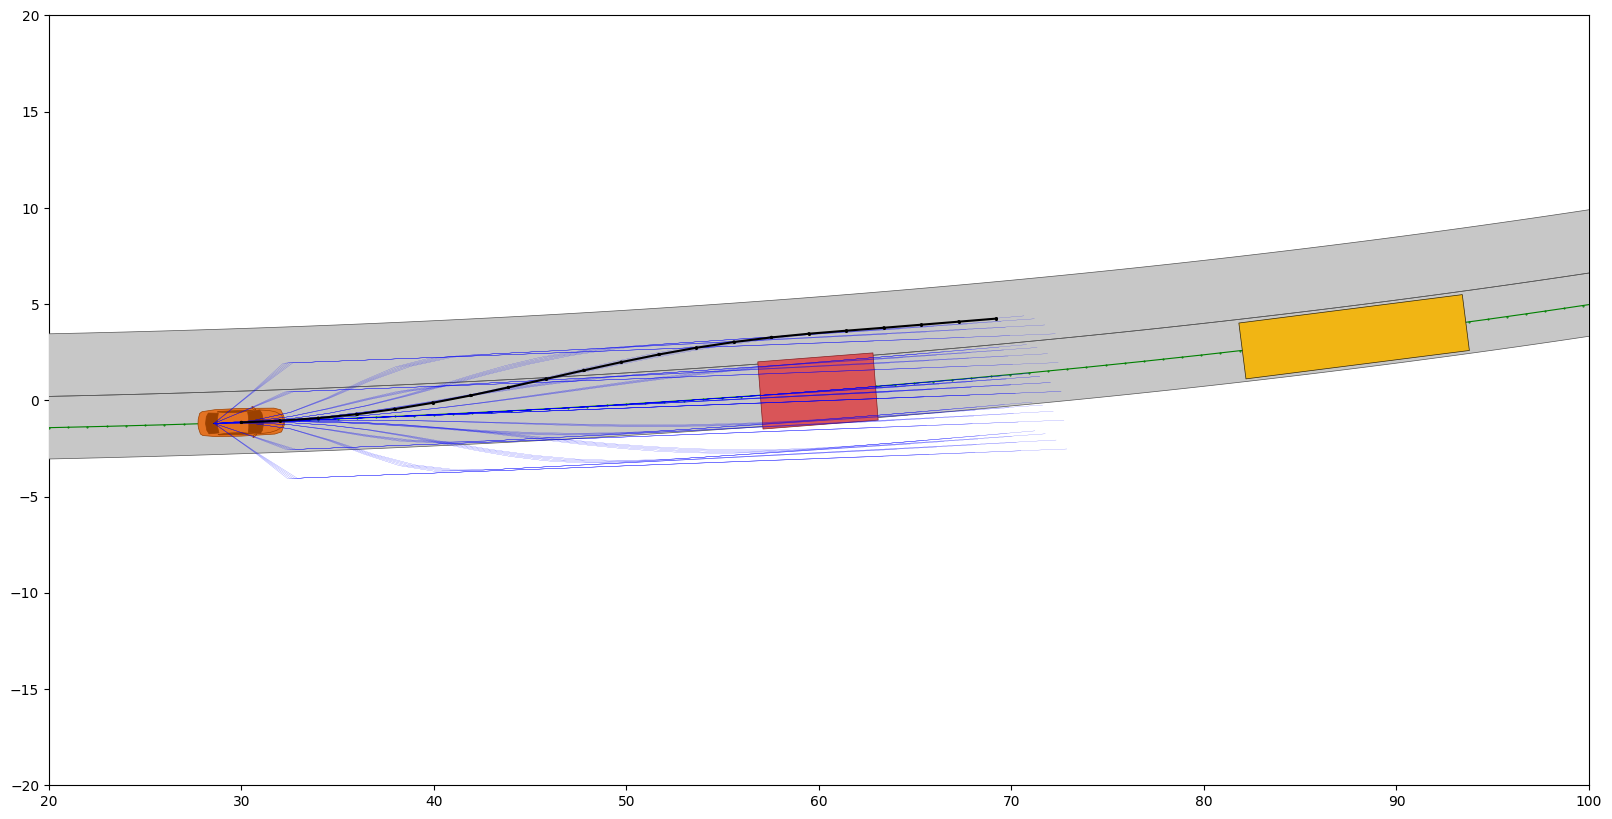

In [5]:
from copy import deepcopy
from commonroad_rp.utility.visualization import visualize_planner_at_timestep

# Add first state to recorded state and input list
planner.record_state_and_input(planner.x_0)

# set desired velocity. Here we just maintain the current speed
planner.set_desired_velocity(current_speed=planner.x_0.velocity)

# call plan function
# the output is a tuple of the planning result, consisting of the Cartesian and Curvilinear planned trajectory
optimal = planner.plan()

# retrieve the Cartesian trajectory
planned_traj_cart = optimal[0]

# for visualization we create the ego vehicle and store the generated set of trajectories
ego_vehicle = planner.convert_state_list_to_commonroad_object(optimal[0].state_list)
sampled_trajectory_bundle = deepcopy(planner.stored_trajectories)

# visualize 
visualize_planner_at_timestep(scenario=config.scenario, planning_problem=config.planning_problem,
                              ego=ego_vehicle, traj_set=sampled_trajectory_bundle,
                              ref_path=planner.reference_path, timestep=0, config=config,
                              plot_limits=[20, 100, -20, 20])

## Run planner with cyclic replanning
We now demonstrate how to run the planner in a receding horizon fashion, i.e., by replanning the trajectory at a fixed replanning frequency. The parameter `replanning_frequency` is specified in the planner configuration and set to 3 time steps for this example.

In [6]:
# replan until ego vehicle has reached the goal
while not planner.goal_reached():
    current_count = len(planner.record_state_list) - 1
    # check if planning cycle or not
    plan_new_trajectory = current_count % config.planning.replanning_frequency == 0

    # new planning cycle -> plan a new optimal trajectory
    if plan_new_trajectory:
        # set velocity
        planner.set_desired_velocity(current_speed=planner.x_0.velocity)

        # call plan function
        optimal = planner.plan()

        # record planned state and input
        planner.record_state_and_input(optimal[0].state_list[1])

        # reset planner state for re-planning
        planner.reset(initial_state_cart=planner.record_state_list[-1], 
                      initial_state_curv=(optimal[2][1], optimal[3][1]),
                      collision_checker=planner.collision_checker, 
                      coordinate_system=planner.coordinate_system)

    # simulate scenario one step forward with planned trajectory
    else:
        # continue on optimal trajectory
        temp = current_count % config.planning.replanning_frequency

        # record state and input
        planner.record_state_and_input(optimal[0].state_list[1 + temp])

        # reset planner state for re-planning
        planner.reset(initial_state_cart=planner.record_state_list[-1],
                      initial_state_curv=(optimal[2][1 + temp], optimal[3][1 + temp]),
                      collision_checker=planner.collision_checker, 
                      coordinate_system=planner.coordinate_system)

We now visualize the planning result, i.e., the driven trajectory of the ego vehicle in this scenario.

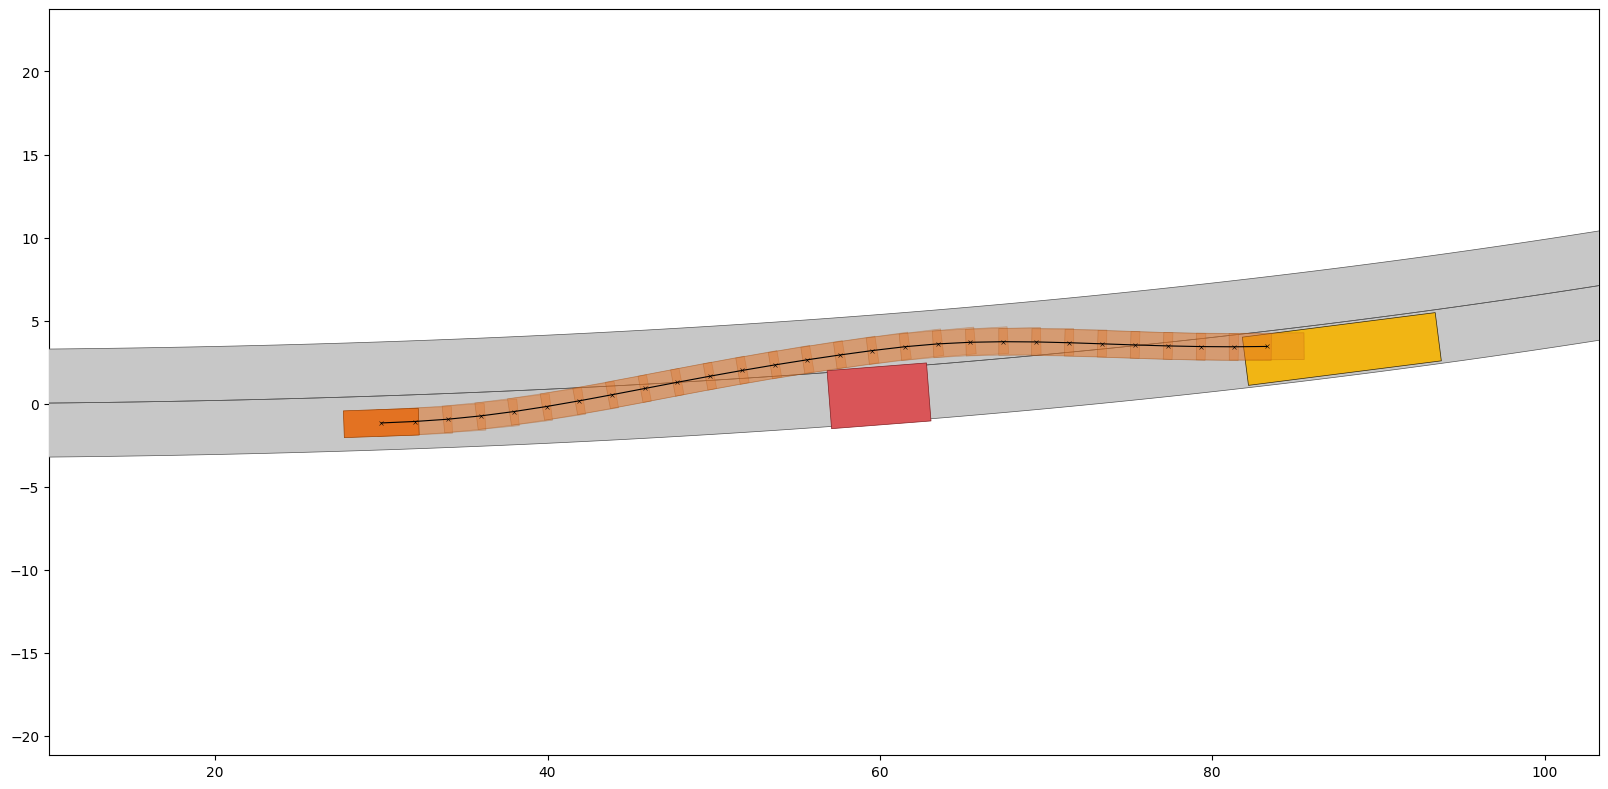

In [7]:
from commonroad_rp.utility.evaluation import create_full_solution_trajectory
from commonroad_rp.utility.visualization import plot_final_trajectory

# create driven trajectory from planned states
ego_solution_trajectory = create_full_solution_trajectory(config, planner.record_state_list)

# visualized driven trajectory
plot_final_trajectory(config.scenario, config.planning_problem, ego_solution_trajectory.state_list, config)